### JHU-CROWD++ Processing, Dataset, and Model

Dataset Source: http://www.crowd-counting.com/

Note: in this ground-truth files, there appear to be points for the heads that are not inside the image. For the purposes of this project, such points with coordinates exceeding the images' borders will be excluded from the ground truths. This ensures we are training our model on information fully present in the image.

In [1]:
#!pip freeze > requirements.txt

In [2]:
!pip install imbalanced-learn
!pip install graphviz
!pip install tensorflow-probability

# to generate gifs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-3er2yfge
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-3er2yfge
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=184468 sha256=b06dab74adb06d5ac51945edabdc0229c2182aac2578ad8ae95393504ad0330b
  Stored in directory: /tmp/pip-ephem-wheel-cache-h1oz3xsn/wheels/3b/ee/a2/ab4d36a9a4af495bcb936f3e849d4b497b65fa40548a68d6c3
Successfully built tensorflow-docs


In [3]:
# import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import IPython
import IPython.display

import warnings

warnings.filterwarnings("ignore")

import os
import zipfile

import PIL
from PIL import Image

import cv2

import numbers
import collections

### JHU-CROWD++ Dataset

In [4]:
# Load the data from Google Drive
# Data sourced from
# http://www.crowd-counting.com/
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
with zipfile.ZipFile('/content/drive/MyDrive/jhu_crowd_v2.0.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/jhu_crowd')

In [6]:
base_dir = '/content/jhu_crowd/jhu_crowd_v2.0'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [7]:
os.listdir(train_dir)

['images', 'image_labels.txt', 'gt']

In [8]:
# Custom transforms implementations credited to
# https://github.com/mlagunas/pytorch-nptransforms/blob/master/np_transforms.py

In [9]:
def _is_numpy_image(img):
    return isinstance(img, np.ndarray)

In [10]:
def crop(pic, i, j, h, w):
    if not _is_numpy_image(pic):
        raise TypeError('img should be Numpy Image. Got {}'.format(type(pic)))

    return pic[i:i + h, j:j + w, :]

In [15]:
from torchvision.io import read_image, ImageReadMode
import torchvision.transforms.functional as TF

In [16]:
# Dataset object for this data
class JHUCrowdDataset(Dataset):
    def __init__(self, gt_dir, img_dir, transform=None, target_transform=None):
        self.gt_dir = gt_dir
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        # Debug: print gt file name (matches image file name)
        # print(sorted(os.listdir(self.gt_dir))[idx])
        gt_path = os.path.join(self.gt_dir, sorted(os.listdir(self.gt_dir))[idx])
        img_path = os.path.join(self.img_dir, sorted(os.listdir(self.img_dir))[idx])

        # image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        image = read_image(img_path, ImageReadMode.RGB).float()/255
        #print(len(image))
        if len(image) == 1:
            image = torch.cat([image, image, image], dim=0)
        labels = self.getCoords(gt_path, image.shape[1:])

        #print(np.sum(labels))
        #print(labels.shape)
        
        if self.transform:
            #print(image.shape)
            image = self.transform(image)
            #print(image.shape)

        #if idx % 20 == 0:
          #print(idx)
        image = TF.center_crop(image, (256,256))
        # print(labels.sum())
        labels_gt = TF.center_crop(labels, (64,64))
        # print(labels_gt.sum())

        if self.target_transform:
            #labels = torch.from_numpy(labels)
            #print(torch.sum(labels))
            #print(labels.shape)
            labels = self.target_transform(labels_gt)
            #print('g')
            #print(torch.sum(labels))

            #labels = transforms.Lambda(lambda x: torch.where(x > 0.0, 1.0, 0.0))(labels)
            
            #print('schlatt')
            #print(torch.sum(labels))
            #print('a')

        #print(labels.sum())
        # (i, j) is the crop's starting point
        # (h, w) is the crop's size

        # i, j, h, w = transforms.RandomCrop.get_params(
        #     image, output_size=(256, 256))
        # image = TF.crop(image, i, j, h, w)
        # print(labels.sum())
        # labels = TF.crop(labels, (i + int(h/4)), (j + int(w/4)), 128, 128)
        # print(labels.sum())

        # print(idx)
        # image = TF.center_crop(image, (256,256))
        # print(labels.sum())
        # labels = TF.center_crop(labels, (64,64))
        # print(labels.sum())
        
        # if self.gaussian:
        #     labels = self.gaussian(labels)
        #print(torch.sum(labels))
        # print(idx)
        # print(image.shape)
        #print(labels.shape)
        # print(i,j,h,w)
        # print((i + int(h/4)), (j + int(h/4)), 128, 128)
        return image, labels, labels_gt
    
    # Return an np array with all the heads' coordinates
    # Storing the ground truths in an array makes transforms easier
    def getCoords(self, gt_path, image_shape):
        resize_factor = min(image_shape[0], image_shape[1]) / 128
        faces = torch.zeros(
            int(image_shape[0] / resize_factor),
            int(image_shape[1] / resize_factor)
        )
        #print(faces.shape)
        with open(gt_path,'r') as data_file:
            for line in data_file:
                data = line.split()
                #data_y = min(int(data[1]), faces.shape[0] - 1)
                #data_x = min(int(data[0]), faces.shape[1] - 1)
                data_y = int(int(data[1]) / resize_factor)
                data_x = int(int(data[0]) / resize_factor)
                if data_y >= faces.shape[0] or data_x >= faces.shape[1]:
                    continue
                # if data_y > faces.shape[0]:
                #     #data_y = faces.shape[0]
                #     continue
                # elif data_x > faces.shape[1]:
                #     #data_x = faces.shape[1]
                #     continue
                faces[data_y, data_x] += 1

        #print('corn dog')
        #print(np.sum(faces))
        #print(faces.shape)
        #faces = faces.reshape(1, *faces.shape)
        #print(faces.shape)
        return faces.unsqueeze(0)

In [17]:
# Apply transforms
# transformer = transforms.Compose([
#     Scale(size=(512,512)),
#     RandomCrop(size=(512,512)),
#     Normalize_01(),
#     ToTensor()
# ])

transformer = transforms.Compose([
    transforms.Resize(512),
])
target_transformer = transforms.Compose([
    transforms.GaussianBlur(11, (3, 3)),
])

In [18]:
# Get directories
train_gt_dir = os.path.join(train_dir, 'gt')
train_img_dir = os.path.join(train_dir, 'images')
val_gt_dir = os.path.join(val_dir, 'gt')
val_img_dir = os.path.join(val_dir, 'images')
test_gt_dir = os.path.join(test_dir, 'gt')
test_img_dir = os.path.join(test_dir, 'images')

In [19]:
# Create datasets

train_data = JHUCrowdDataset(train_gt_dir, train_img_dir, transform=transformer, target_transform=target_transformer)
train_data_nb = JHUCrowdDataset(train_gt_dir, train_img_dir, transform=transformer)
val_data = JHUCrowdDataset(val_gt_dir, val_img_dir, transform=transformer, target_transform=target_transformer)
#test_data = JHUCrowdDataset(test_gt_dir, test_img_dir, transform=transformer, target_transform=target_transformer)

In [20]:
# Create subsets of agreed-upon sizes, comment to use the full dataset
# train_subset = torch.utils.data.Subset(train_data, range(500))
# val_subset = torch.utils.data.Subset(train_data, range(100))
# test_subset = torch.utils.data.Subset(train_data, range(200))
# type(train_subset)

In [21]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=False)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=False)
#test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

In [22]:
# Run through a batch to confirm it loads properly
for i, data in enumerate(val_dataloader):
    print(data[0].shape)
    print(data[1].shape)
    print(data[2].shape)
    break

torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])


torch.Size([3, 256, 256]) torch.Size([1, 64, 64])


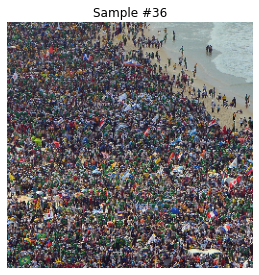

In [23]:
# Visualize one of the images
# fig = plt.figure(figsize=(10, 10))

# for i in range(len(train_dataset)):
i = 36
sample = train_data[i]

print(sample[0].shape, sample[1].shape)

ax = plt.subplot(1, 1, 1)
plt.tight_layout()
ax.set_title('Sample #{}'.format(i))
ax.axis('off')

plt.imshow(sample[0].permute(1,2,0))
# Render image

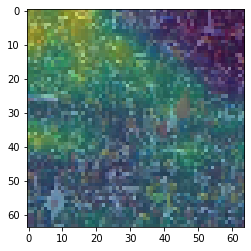

In [24]:
plt.imshow(sample[0].permute(1,2,0))
plt.imshow(sample[1][0,:,:], alpha=0.5)
# Render Gaussian distribution

In [25]:
# Count how many people are in the Gaussian versus the ground truth
sample[1].sum(), sample[2].sum() #train_data_nb[i][1].sum(), train_data[i][1].sum()

(tensor(4625.8447), tensor(4627.))

In [26]:
# Resized ground truth with no Gaussian
(train_data_nb[i][1])[0].shape

torch.Size([128, 192])

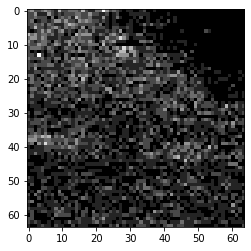

In [27]:
# Render ground truth with no Gaussian
plt.imshow((sample[2])[0], cmap="gray")

In [28]:
# plt.figure(figsize=(10, 10))
# plt.imshow((sample[1]).permute(1, 2, 0), cmap="gray")

In [29]:
from torch import nn
from torchvision import models
import torchsummary

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [31]:
DEVICE = torch.device('cuda:0')

### CG-DRCN Architecture

In [32]:
# Implementing CG-DRCN model from paper specifications
# Source: http://www.crowd-counting.com/assets/img/jhucrowdv1_iccv19.pdf

class CGDRCN(nn.Module):
  def __init__(self):
    super().__init__()
    self.vgg16_model = models.vgg16(pretrained=True)
    self.C1 = list(self.vgg16_model.children())[0][0:4]
    self.C2 = list(self.vgg16_model.children())[0][5:10]
    self.C3 = list(self.vgg16_model.children())[0][10:17]
    self.C4 = list(self.vgg16_model.children())[0][17:24]
    self.C5 = list(self.vgg16_model.children())[0][24:]
    self.CB6 = nn.Sequential(
        nn.Conv2d(512, 32, 1, stride=1),
        nn.ReLU(),
        nn.Conv2d(32, 32, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 1, 3, stride=1, padding=1),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.CB5 = nn.Sequential(
        nn.Conv2d(512, 32, 1, stride=1),
        nn.ReLU(),
        nn.Conv2d(32, 32, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 1, 3, stride=1, padding=1),
    )
    self.CB4 = nn.Sequential(
        nn.Conv2d(512, 32, 1, stride=1),
        nn.ReLU(),
        nn.Conv2d(32, 32, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 1, 3, stride=1, padding=1),
    )
    self.CB3 = nn.Sequential(
        nn.Conv2d(256, 32, 1, stride=1),
        nn.ReLU(),
        nn.Conv2d(32, 32, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 1, 3, stride=1, padding=1),
    )

    self.DR5 = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=32, kernel_size=1)
    )
    self.DR4 = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=32, kernel_size=1)
    )
    self.DR3 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=32, kernel_size=1)
    )

    self.CEB5 = nn.Sequential(
        nn.Conv2d(33, 32, 1, stride=1),
        nn.ReLU(),
        nn.Conv2d(32, 16, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 16, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 1, 1, stride=1),
        nn.ReLU(),
    )
    self.CEB4 = nn.Sequential(
        nn.Conv2d(33, 32, 1, stride=1),
        nn.ReLU(),
        nn.Conv2d(32, 16, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 16, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 1, 1, stride=1),
        nn.ReLU(),
    )
    self.CEB3 = nn.Sequential(
        nn.Conv2d(33, 32, 1, stride=1),
        nn.ReLU(),
        nn.Conv2d(32, 16, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 16, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 1, 1, stride=1),
        nn.ReLU(),
    )

    self.up = nn.Sequential(
        nn.Upsample(scale_factor = 2, mode = 'bilinear')
    )
  def forward(self, x):
    #print(x.shape)
    F1 = self.C1(x)
    F2 = self.C2(F1)
    F3 = self.C3(F2)
    F4 = self.C4(F3)
    F5 = self.C5(F4)
    #print('F5', F5.shape)
    Yhat6 = self.CB6(F5)

    dimRed5 = self.DR5(F5)
    # print(dimRed5.shape)
    R5 = self.CB5(F5)
    # print(R5.shape)
    concat5 = torch.concat((dimRed5, R5), 1)
    CM5 = self.CEB5(concat5)
    Rhat5 = torch.mul(R5, CM5)

    dimRed4 = self.DR4(F4)
    #print(dimRed4.shape)
    R4 = self.CB4(F4)
    #print(R4.shape)
    concat4 = torch.concat((dimRed4, R4), 1)
    #print(concat4.shape)
    CM4 = self.CEB4(concat4)
    #print(CM4.shape)
    Rhat4 = torch.mul(R4, CM4)
    #print(Rhat4.shape)

    dimRed3 = self.DR3(F3)
    R3 = self.CB3(F3)
    concat3 = torch.concat((dimRed3, R3), 1)
    CM3 = self.CEB3(concat3)
    Rhat3 = torch.mul(R3, CM3)

    Yhat5 = Rhat5 + self.up(Yhat6)
    Yhat4 = Rhat4 + self.up(Yhat5)
    Yhat3 = Rhat3 + self.up(Yhat4)

    CMi = (CM3, CM4, CM5, Yhat6)
    Yi = (F3, F4, F5, Yhat6)
    Yhati = (Yhat3, Yhat4, Yhat5, Yhat6)

    return Yhat3, CMi, Yi, Yhati

In [ ]:
cgdrcn = CGDRCN()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
# Test-run an image of the equivalent size we will use
torchsummary.summary(cgdrcn, (3,256,256))

NameError: ignored

In [ ]:
data[0].shape

torch.Size([64, 3, 256, 256])

In [ ]:
data = train_data[35]
image = torch.tensor(data[0], dtype=torch.float32)
print(image.shape, image.dtype)
print(data[1].shape)
out, CMi, Yi, Yhati = cgdrcn( torch.stack([image]) )

35
tensor(3.)
tensor(1.)
tensor(1.0000)
torch.Size([1, 64, 64])
torch.Size([3, 256, 256]) torch.float32
torch.Size([1, 64, 64])
torch.Size([1, 32, 16, 16])
torch.Size([1, 1, 16, 16])


In [ ]:
out[0].sum()

In [33]:
import seaborn as sns 
sns.set_theme()

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(sample[0][0,:,:], cmap='gray')
plt.imshow(out[0][0].detach().numpy(), alpha=0.5)

In [ ]:
sample[1][0,:,:].sum()

tensor(4625.8447)

In [ ]:
out[0].sum()

In [ ]:
ax = sns.heatmap(out[0][0].detach().numpy(), cmap="Reds")

In [ ]:
imres = out[0][0].detach()
imresFix = transforms.Lambda(lambda x: torch.where(abs(x) > 0.07, 1.0, 0.0))(imres)
ax = sns.heatmap(imresFix.numpy(), cmap="Reds")

In [ ]:
imresFix.sum()

NameError: ignored

In [34]:
import torch.nn.functional as nn_F

In [ ]:
print(Yi[0].shape)

torch.Size([1, 256, 64, 64])


### CG-DRCN Loss Function

In [35]:
class CGDRCNLoss(nn.Module):
  def __init__(self, lambda_c):
    super().__init__()
    self.lambda_c = lambda_c
  def forward(self, CMi, Yi, Yhati):
    loss_d = 0
    for i in range(len(CMi)):
      #for j in range(len(CMi[0])):
      #print(i + 3)
      # print('real')
      # print(CMi[i].shape)
      # print(Yi[i].shape)
      real = torch.multiply(CMi[i][0][0], Yi[i][0][0])
      # print(real.shape)
      # print('pred')
      # print(CMi[i].shape)
      # print(Yhati[i].shape)
      pred = torch.multiply(CMi[i][0][0], Yhati[i][0][0])
      # print(pred.shape)
    #   print('DEBUG')
    #   print(real.shape)
    #   print(pred.shape)
    #   loss_d += torch.linalg.norm((real[0] - pred), ord = 2)
    # print(loss_d)
    loss_c = 0
    for i in range(len(CMi)):
      #print(CMi[i])
      loss_c += torch.sum(torch.log(CMi[i]))
    # print(loss_c)

    loss_full = loss_d - self.lambda_c * loss_c

    return loss_full

In [ ]:
np.asarray(data[1])

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [ ]:
Yi[3].shape

In [36]:
import torchvision.transforms.functional as fn

In [ ]:
Yi64 = torch.tensor(fn.resize(data[0], size=[64,64]), dtype=torch.float32)
Yi32 = torch.tensor(fn.resize(data[0], size=[32,32]), dtype=torch.float32)
Yi16 = torch.tensor(fn.resize(data[0], size=[16,16]), dtype=torch.float32)
Yi8 = torch.tensor(fn.resize(data[0], size=[8,8]), dtype=torch.float32)

Yi64g = transforms.Grayscale()(Yi64)
Yi32g = transforms.Grayscale()(Yi32)
Yi16g = transforms.Grayscale()(Yi16)
Yi8g = transforms.Grayscale()(Yi8)

Yi = (torch.stack([Yi64g]), torch.stack([Yi32g]), torch.stack([Yi16g]),
      torch.stack([Yi8g]))

loss_func = CGDRCNLoss(1)

In [ ]:
loss_v = loss_func(CMi, Yi, Yhati)
loss_v

In [37]:
from torch import optim

In [ ]:
cgdrcn = CGDRCN()
optimizer = optim.Adam(cgdrcn.parameters(), lr=0.00001)
loss_fn = CGDRCNLoss(1)

dataIntegra = train_data[0]
print(image.shape)
image = dataIntegra[0]
optimizer.zero_grad()
out, CMi, Yi, Yhati = cgdrcn(torch.stack([image]))

In [ ]:
loss_val = loss_func(out[0], Yi, Yhati)
loss_val

### CG-DRCN Training Loop

In [168]:
from tqdm.notebook import tqdm
import copy
import time
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
import math
!pip install -q tensorboard

In [169]:
DEVICE = torch.device('cuda:0')

In [170]:
!nvidia-smi

Mon Dec 12 03:31:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    29W /  70W |  14888MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [171]:
CHECKPOINT_FOLDER = Path(r"/content/jhu/checkpoints")

In [172]:
!ln -s /content/jhu/checkpoints checkpoints

ln: failed to create symbolic link 'checkpoints': File exists


In [173]:
import pdb

In [174]:
@torch.no_grad()
def val_acc(m, valloader):
  loss_list_full = []
  loss_list_mae = []
  loss_list_mse = []
  m = m.eval()
  loss_func = CGDRCNLoss(1)
  #indexVal = 0
  for image, labels, labels_gt in valloader:
    #print(indexVal)
    #breakpoint()
    image = image.to(DEVICE)
    labels = labels.to(DEVICE)
    labels_gt = labels_gt.to(DEVICE)
    #out, CMi, Yi, Yhati = cgdrcn(torch.stack([image]))
    out, CMi, Yi, Yhati = cgdrcn(image)
    
    Yi64 = torch.tensor(fn.resize(image, size=[64,64]), dtype=torch.float32)
    Yi32 = torch.tensor(fn.resize(image, size=[32,32]), dtype=torch.float32)
    Yi16 = torch.tensor(fn.resize(image, size=[16,16]), dtype=torch.float32)
    Yi8 = torch.tensor(fn.resize(image, size=[8,8]), dtype=torch.float32)

    Yi64g = transforms.Grayscale()(Yi64)
    Yi32g = transforms.Grayscale()(Yi32)
    Yi16g = transforms.Grayscale()(Yi16)
    Yi8g = transforms.Grayscale()(Yi8)

    Yi = (torch.stack([Yi64g]), torch.stack([Yi32g]), torch.stack([Yi16g]),
          torch.stack([Yi8g]))
    
    loss_val = loss_func(CMi, Yi, Yhati)
    loss_mae = torch.abs(labels_gt.sum() - out[0].sum())
    loss_mse = torch.square(torch.abs(labels_gt.sum() - out[0].sum()))
    loss_list_full.append(loss_val)
    loss_list_mae.append(loss_mae.item())
    loss_list_mse.append(loss_mse.item())

    del image
    del labels
    del labels_gt
    #indexVal += 1
  
  return sum(loss_list_full) / len(loss_list_full),\
          sum(loss_list_mae) / len(loss_list_mae),\
          math.sqrt(sum(loss_list_mse) / len(loss_list_mse))

In [176]:
def train(epoch, m, loss_fn, optimizer, trainloader, valloader=None, best_epoch_start=200):
  pbar = tqdm(range(epoch))
  loss_list = []
  val_acc_list = []
  val_mae = 0.
  val_mse = 0.
  best_model = copy.deepcopy(m.state_dict())
  best_val_acc = 0.
  best_epoch = best_epoch_start
  total_time = 0.

  writer = SummaryWriter()

  for i in pbar:
    print('epoch start')
    sub_loss_list = []

    m = m.train()
    start = time.time()

    for image, labels, labels_gt in trainloader:
      image = image.to(DEVICE)
      labels = labels.to(DEVICE)
      labels_gt = labels_gt.to(DEVICE)

      # forward
      out, CMi, Yi, Yhati = m(image)

      # calculate loss
      Yi64 = torch.tensor(fn.resize(image, size=[64,64]), dtype=torch.float32)
      Yi32 = torch.tensor(fn.resize(image, size=[32,32]), dtype=torch.float32)
      Yi16 = torch.tensor(fn.resize(image, size=[16,16]), dtype=torch.float32)
      Yi8 = torch.tensor(fn.resize(image, size=[8,8]), dtype=torch.float32)

      Yi64g = transforms.Grayscale()(Yi64)
      Yi32g = transforms.Grayscale()(Yi32)
      Yi16g = transforms.Grayscale()(Yi16)
      Yi8g = transforms.Grayscale()(Yi8)

      Yi = (torch.stack([Yi64g]), torch.stack([Yi32g]), torch.stack([Yi16g]),
            torch.stack([Yi8g]))
    
      optimizer.zero_grad()
      loss = loss_fn(CMi, Yi, Yhati)
      loss_num = loss.item()
      sub_loss_list.append(loss_num)
      #pbar.set_description(f'val_acc_lr={val_acc_lr:.4} val_acc_hr={val_acc_hr:.4} loss={loss_num:.4}') 
      pbar.set_description(f'val_mae={val_mae:.4} val_mse={val_mse:.4} loss={loss_num:.4}')

      # backaward
      loss.backward()
      optimizer.step()

    end = time.time()

    if valloader is not None:
      print('val')
      val_loss, val_mae, val_mse = val_acc(m, valloader)
      pbar.set_description(f'val_mae={val_mae:.4} val_mse={val_mse:.4} loss={loss_num:.4}') 
      val_acc_list.append([val_loss, val_mae, val_mse])
      # if (i > best_epoch) and (val_acc_v > best_val_acc):
      #   best_epoch = i
      #   best_val_acc = val_acc_v
      #   best_model = copy.deepcopy(m.state_dict())

    # checkpoint
    # checkpoint = {}
    # checkpoint['weights'] = m.state_dict()
    # checkpoint['epoch'] = i + 1
    # checkpoint['loss'] = loss_num
    #torch.save(checkpoint, CHECKPOINT_FOLDER / f'cgdrcn.pt')
    
    total_time = total_time + (end - start)
    epoch_loss = sum(sub_loss_list) / len(sub_loss_list)
    loss_list.append(epoch_loss)

    # tensorflow
    writer.add_scalar("Loss/train", epoch_loss, i)
    writer.add_scalar("time", end-start, i)

    writer.flush()

  print(f'\ntraining finished in {total_time}s. Best model at epoch={best_epoch} with val_acc={best_val_acc}')
  # m.load_state_dict(best_model)
  writer.flush()
  writer.close()
  return loss_list, val_acc_list

### Running Training

In [186]:
# 90% training, 10% validation
from torch.utils.data import DataLoader
train_set = JHUCrowdDataset(train_gt_dir, train_img_dir, transform=transformer, target_transform=target_transformer)
train_subset = torch.utils.data.Subset(train_data, range(432))
trainloader = DataLoader(train_subset, batch_size=24, shuffle=False)

val_set = JHUCrowdDataset(val_gt_dir, val_img_dir, transform=transformer, target_transform=target_transformer)
val_subset = torch.utils.data.Subset(train_data, range(48))
valloader = DataLoader(val_subset, batch_size=24, shuffle=False)

In [187]:
DEVICE = torch.device('cuda:0')

In [188]:
from torch import optim
DEVICE = torch.device('cuda:0')
cgdrcn = CGDRCN()
cgdrcn = cgdrcn.to(DEVICE)
optimizer = optim.Adam(cgdrcn.parameters(), lr=0.00001)
loss_fn = CGDRCNLoss(1) 

In [189]:
# manual lr control
# params = optimizer.state_dict()
# optimizer = optim.SGD(cgdrcn.parameters(), lr=0.00001, momentum=0.9)
# optimizer.load_state_dict(params)

In [190]:
# resume from checkpoint
# ckpt = torch.load('checkpoints/cgdrcn.pt')
# cgdrcn.load_state_dict(ckpt["weights"])

In [191]:
# !pip install -q torchinfo
# import torchinfo
# model = cgdrcn.to('cuda:0')
# torchinfo.summary(model, (-1,3,512,512))
import torchsummary
model = cgdrcn.to('cuda:0')
torchsummary.summary(model, (3,256,256), batch_size=1)
del model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 256, 256]           1,792
            Conv2d-2          [1, 64, 256, 256]           1,792
              ReLU-3          [1, 64, 256, 256]               0
              ReLU-4          [1, 64, 256, 256]               0
            Conv2d-5          [1, 64, 256, 256]          36,928
            Conv2d-6          [1, 64, 256, 256]          36,928
              ReLU-7          [1, 64, 256, 256]               0
              ReLU-8          [1, 64, 256, 256]               0
            Conv2d-9         [1, 128, 256, 256]          73,856
           Conv2d-10         [1, 128, 256, 256]          73,856
             ReLU-11         [1, 128, 256, 256]               0
             ReLU-12         [1, 128, 256, 256]               0
           Conv2d-13         [1, 128, 256, 256]         147,584
           Conv2d-14         [1, 128, 2

In [192]:
cgdrcn = cgdrcn.to(DEVICE)

In [193]:
loss_list, v_loss_list = train(50, cgdrcn, loss_fn, optimizer, trainloader, valloader=valloader, best_epoch_start=200)

  0%|          | 0/50 [00:00<?, ?it/s]

epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val
epoch start
val

training finished in 1683.455809354782s. Best model at epoch=200 with val_acc=0.0


### Results

In [194]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<IPython.core.display.Javascript object>

In [195]:
loss_list

[nan,
 nan,
 nan,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 -385093.1927083333,
 -407433.7986111111,
 -429351.0017361111,
 -450888.609375,
 -472085.5572916667,
 -492974.2916666667,
 -513582.82465277775,
 -533914.4479166666,
 -553957.0381944445,
 -573711.1527777778,
 -593215.2569444445,
 -612466.2395833334,
 -631461.8402777778,
 -650215.9270833334,
 -668756.2361111111,
 -687135.6180555555,
 -705483.0451388889,
 -724235.5243055555,
 -743501.3958333334,
 -763064.2152777778,
 -782461.6701388889,
 -801564.5243055555,
 -820360.8020833334,
 -838851.8125,
 -857055.3958333334,
 -874981.9236111111,
 -892647.96875,
 -910077.3229166666,
 -927295.3090277778]

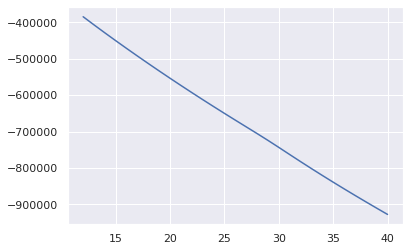

In [196]:
plt.plot(loss_list[9:])

In [201]:
@torch.no_grad()
def drawEval(model, dataset):
  model = model.to('cpu')
  data = dataset[0]
  image = torch.tensor(data[0], dtype=torch.float32)
  print(image.shape, image.dtype)
  print(len(data[1]))
  out, CMi, Yi, Yhati = cgdrcn(torch.stack([image]))

  plt.imshow( np.asarray(np.transpose(data[0], (1,2,0)), dtype=np.int8) )

  sns.heatmap(out[0].numpy()[0], cmap="Reds")
  # sns.heatmap(out[1].detach().numpy()[0], cmap="Reds")
  
  sns.heatmap(data[1][0], cmap="Reds")

torch.Size([3, 256, 256]) torch.float32
1


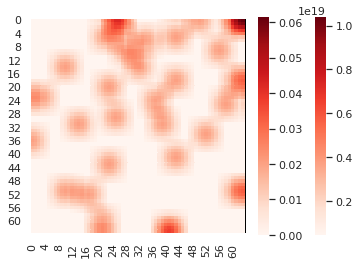

In [202]:
drawEval(cgdrcn, train_set)

In [203]:
model = cgdrcn.to('cpu')

torch.Size([3, 256, 256]) torch.float32
tensor(144.4402)
torch.Size([3, 256, 256])


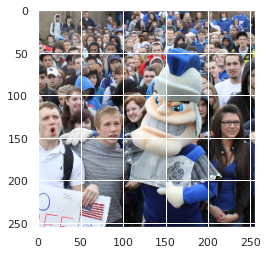

In [204]:
data = train_set[123]
image = torch.tensor(data[0], dtype=torch.float32)
print(image.shape, image.dtype)
print(data[1].sum())
print(image.shape)
out, CMi, Yi, Yhati = cgdrcn(torch.stack([image]))

plt.imshow( np.transpose(np.asarray(data[0], dtype=float), (1,2,0)))


# sns.heatmap(out[1].detach().numpy()[0], cmap="Reds")

In [206]:
# Predicted count
torch.sum(out[0])

tensor(3.5403e+22, grad_fn=<SumBackward0>)

In [207]:
# GT
data[2].sum()

tensor(145.)

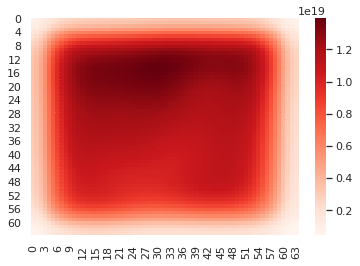

In [208]:
sns.heatmap(out[0].detach().numpy()[0], cmap="Reds")

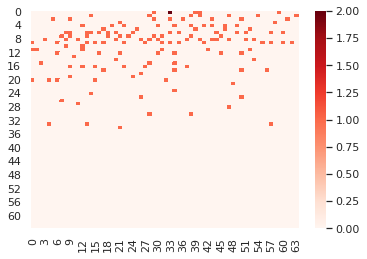

In [209]:
sns.heatmap(data[2][0], cmap="Reds")

### Cleaning

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia_smi